## 1 Introduction

Long term time lapse atomic force microscopy (LTTL-AFM) is a groundbreaking new technique for imaging bacteria in high resolution, developped by Dr Alexander Eskandarian. It allows us to observe how physical properties of the bacterial cell surface, detected by high resolution AFM, change over time. We can then examine how those properties change around important events such as cell division. Eskandarian et al (2017), Hannebelle et al (2020), and Odermatt et al (2020) have all identified such properties by examining this data manually including: wave troughs which division events localize to, furrows which occur several minutes before the development of the FTSZ ring, changes in stiffness on the cell surface, and nano-vesicles appearing on the cell surface. This technique has also made it easy to observe the growth of bacterial cells much more accurately than in previous work (Hannebelle et al, 2020), and we may even relate this growth to the previous physical features  mentioned. 

This project aims to automate the process of finding and detecting biophysical features in images of several cells, and thus produce a large and accurate dataset of them for further study. We would also like to automate the measurement of cell growth and divsion events, both to study them and relate them to relevant biophysical features. This requires images to be processed, aligned, and segmented into masks which must have false masks filtered out, be tracked over time and have their biophysical features identified. Building on a project by Keegan Flannagan and Hasti Delfi several different programs are used to porcess and segment the images, and skeletonize and analyze the masks of cells in them.

Gwyddion (an external desktop program), Cellpose (a neurel-net based python package which segments and creates masks of cells), PyTracker (a program which implements single particle tracking to track cells over time), SciKit Image (a python image processing package which produces skeletons of masks), and a pole-based method for turning skeletons into centerlines of the cell. Then division events can be identified and biophysical features of the cell can be tracked along the centerline. 

## 2. Datasets

## 3. Analysis

### Setup

by Keegan Flannagan and Hasti Delfi

The easiest way to ensure that all the necessary packages and required dependencies for this analysis are installed is to run this analysis within a conda environment. If you are unfamiliar with miniconda, you can learn more about it and download it from the following link https://docs.conda.io/en/latest/miniconda.html.

A conda environment with the complete version of Cellpose pre-installed can be created and activated by entering the following commands into the terminal:
```
conda create --name cellpose python=3.8
conda activate cellpose
```
Once the Cellpose conda environment has been activated, additional required packages can be installed via pip using the following commands:

```
pip install jupyterlab
pip install matplotlib
pip install pandas
pip install imutils
pip install imageio
pip install fil_finder
pip install radfil
pip install skimage
pip install networkx
pip install sklearn
pip install astropy
pip install sknw
```
After all of these installations are complete and this notebook is opened within the Cellpose conda environment, the example analysis is ready to be run. 

### Loading in necessary packages and defining paths

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
from cellpose import utils, io, models, plot
from scipy.spatial import distance as dist
import re
import tools
from radfil import radfil_class, styles
from astropy import units as u
import imageio.v2 as imageio
import copy
from PIL import Image
from fil_finder import FilFinder2D
from shapely.geometry import Polygon
from skimage.util import invert
from skimage.morphology import skeletonize
from cv2 import imwrite
from tools import prune2
from scipy.interpolate import splprep
from scipy.interpolate import splev
from IPython.core.display import HTML
import trackpy
import shutil


date = "30-03-2015"
my_data = "../data/" + date + "/Height/"
my_pfe = "../data/" + date + "/Peak_Force_Error/"
my_apm = "../data/" + date + "/Amplitude/"
my_sti = "../data/" + date + "/Stiffness/"
segments_path = "../cellpose_outputs/" + date + "/Height/"
cell_path = "Individual_cells/"
lin_path = "../lineages/" + date

## 3.1 Segmentation

by Keegan Flannagan and Hasti Delfi

### 3.1.1 Load and sort the initial image files

In [2]:
# Load up a list of input files from our example data.
files = os.listdir(my_data)
for fichier in files[:]:
    if not(fichier.endswith(".png")):
        files.remove(fichier)
        
# Sort files by timepoint.
files.sort(key = tools.natural_keys)      

# Create a list that contains the full path to each of our image files. 
save_names = [segments_path + file for file in files]
file_names = [my_data + file for file in files]

Each image in our example dataset consists of a grayscaled height image wih a scale bar at the side. 

In [ ]:
# view an example image.
img = io.imread(file_names[0])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

### 3.1.2 Run Cellpose

Cellpose is a program which uses a generalist model to perform cell or nucleus segmentation. Cellpose utilizes a deep neural network which was trained on a diverse set of images which comprised over 70,000 individual segmented  objects. This diverse training set allows Cellpose to perform segmentation on a wide range of image types without previous training or parameter adjustment. We are going to use this pre-trained cytoplasm model for our segmentation. 

In [ ]:
# Specify that the cytoplasm Cellpose model for the segmentation. 
model = models.Cellpose(gpu=False, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
channels = [0,0]

# Loop over all of our image files and run Cellpose on each of them. 
for filename, savename in zip(file_names, save_names):
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter = 80, channels=channels, flow_threshold = 0.8)

    # save results so you can load in gui
    io.masks_flows_to_seg(img, masks, flows, diams, savename, channels)

    #save results as png
    io.save_to_png(img, masks, flows, savename)

Below we can see an illustrative example of Cellpose's outputs. Each cell in the original image has an associated outline and mask which cover the perimeter and area of the cell respectively. The image to the far right shows the predicted vector fields for each cell.

In [ ]:
# Display an example of Cellposes output. 
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

The following plot shows the vector flow fields generated by Cellpose. These flow fields are what Cellpose uses to deliminate cells from each other. One can observe that all of the pixels within the individual cells follow a gradient to a single cell centerpoint which is visible as a black dot. This allows Cellpose to map each individual pixel to the center of the cells which is how Cellpose decides if a pixel is inside of a cell. 

In [ ]:
legend = imageio.imread("flow_legend.jpg")
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 1]})
ax[1].axis("off")
ax[0].imshow(flows[0])
ax[1].imshow(legend)

## 3.2 Collect metadata

After the cells in our images have been properly segmented, we will want to analyze the masks and outlines outputted by Cellpose in order to collect data on several cell parameters over time. The parameters we are interested in includes the perimeter of the cell, the area of the cell, the degree to which a cell touches another cell, the location of the cell, the hight along the cells medial axis or skeleton, and the radial profile. We would also like to analyze how these parameters change over time for each cell, so a simple cell tracking algorithm has been implemented in order to keep track of each cell over time. 

### 3.2.1 Load up segmentation files

by Keegan Flannagan and Hasti Delfi

The segmentation files generated in the last step can now be loaded back into Jupyter for analysis. Each of the images and associated segmentation files from the example dataset contain a timepoint within their file names. This makes it easy to sort the data from earliest to latest which will be important for cell tracking and for the organization of the metadata. 

In [3]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

Before the desired cell parameters are estimated, small cell masks/outlines are removed from the segmentation datasets. This is done because small masks are often the result of Cellpose picking up on small visual artifacts present in the AFM data. This simple size filter removes the vast majority of these artifacts. The original image and the cell outlines are then extracted from each of the original segmentation datasets. These outputs will be sufficient to calculate all of the additional parameters needed for the metadata.

In [4]:
# Initialize lists.
outl_temp = []
height_img_list = []

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    
    # Remove small masks from the data
    dat["masks"] = utils.fill_holes_and_remove_small_masks(dat["masks"], min_size = 800)
    
    # Populate list with each cell outline.
    outl = utils.outlines_list(dat['masks'])
    outl_temp.append(outl)
    
    # Populate list with each original image.
    image = dat["img"]
    height_img_list.append(image)

The code below shows an illustrative example of a cell with its associated outline. 

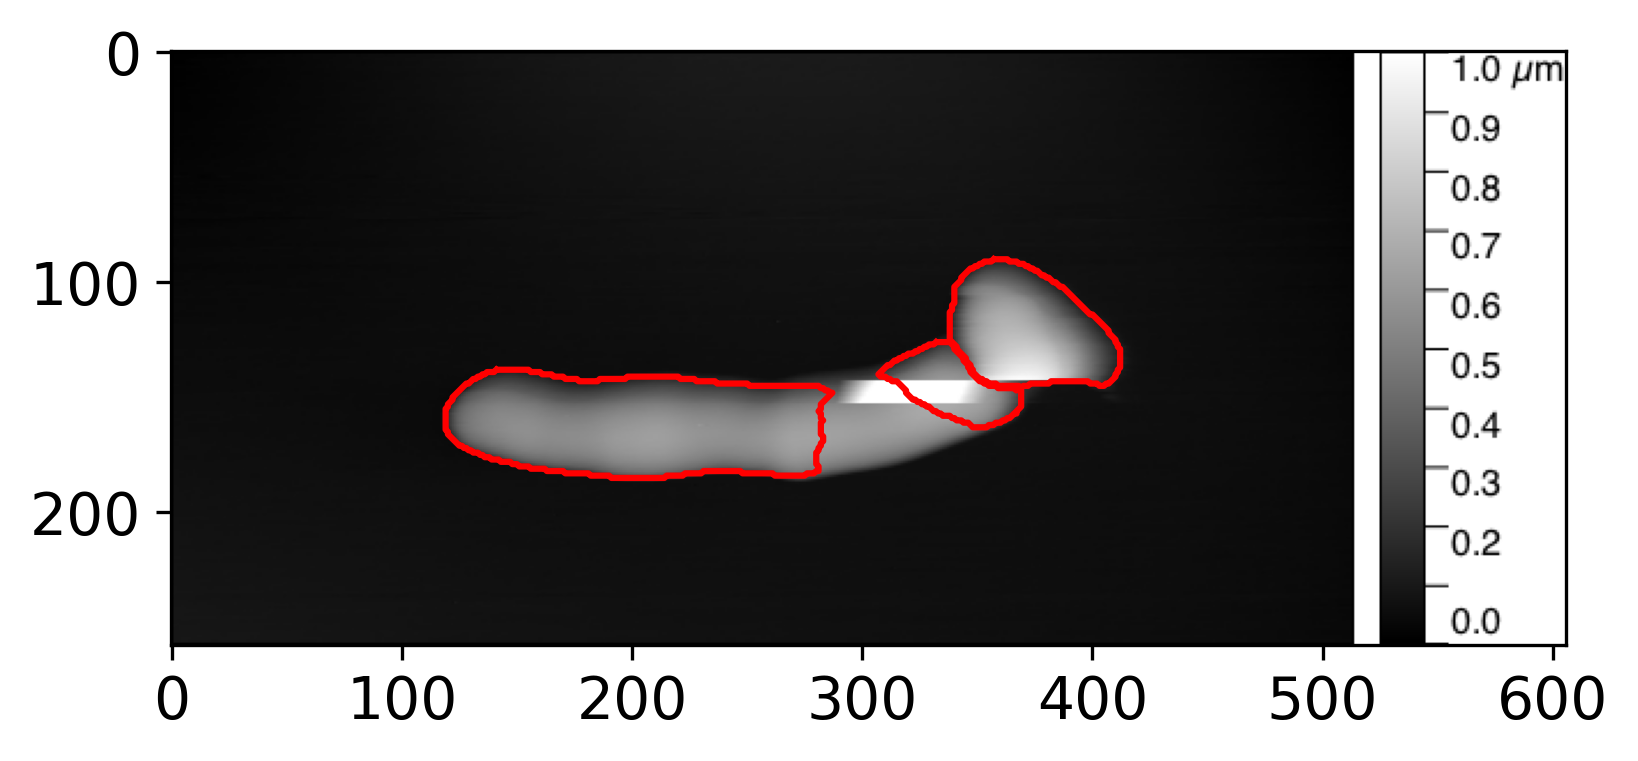

In [5]:
# plotting the original image
plt.imshow(height_img_list[0])
# plotting the outlines. 
for o in outl_temp[0]:
    plt.plot(o[:,0], o[:,1], color='r')

In [6]:
# The image dictionary contains the complete images for all of the image types. 
img_dict = {
    "Height": height_img_list,
    }

# The metadata dictionary will hold all of the data we want to save into our final table.
metadata_dict = {}

# The individual cell dictionary will save information for each individual cell such as the outline, skeleton, cropped image, etc. 
ind_cell_dict = {}

# The structural dictionary will hold information on the timepoint of each image, the cell IDs for each cell in each image,
# and the outlines and bounding boxes for each cell in each image.
structural_dict = {
    "Time": time_list
    }

### 3.2.2 Create bounding boxes for each cell outline

by Keegan Flannagan and Hasti Delfi

A bounding box is the smallest possible rectangle that can contain all of the points within a shape. Creating bounding boxes for each of our cell outlines will allow for the quick computation of the center points (centroids) of each cell which is necessary for cell tracking. Furthermore, detecting bounding box intersections can be used as a quick way to determine if two cells might be touching each other which allows for an optimization of our cell overlap measuring algorithm. 

In [7]:
# Initialize a list of boxes
boxes_temp = []
box_img = copy.deepcopy(height_img_list)

# Fill lists with the coordinates of bounding boxes for each cell outline.
for outl, img in zip(outl_temp, box_img):
    boxes = tools.get_boxes(outl)
    boxes_temp.append(boxes)
    for box in boxes:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)

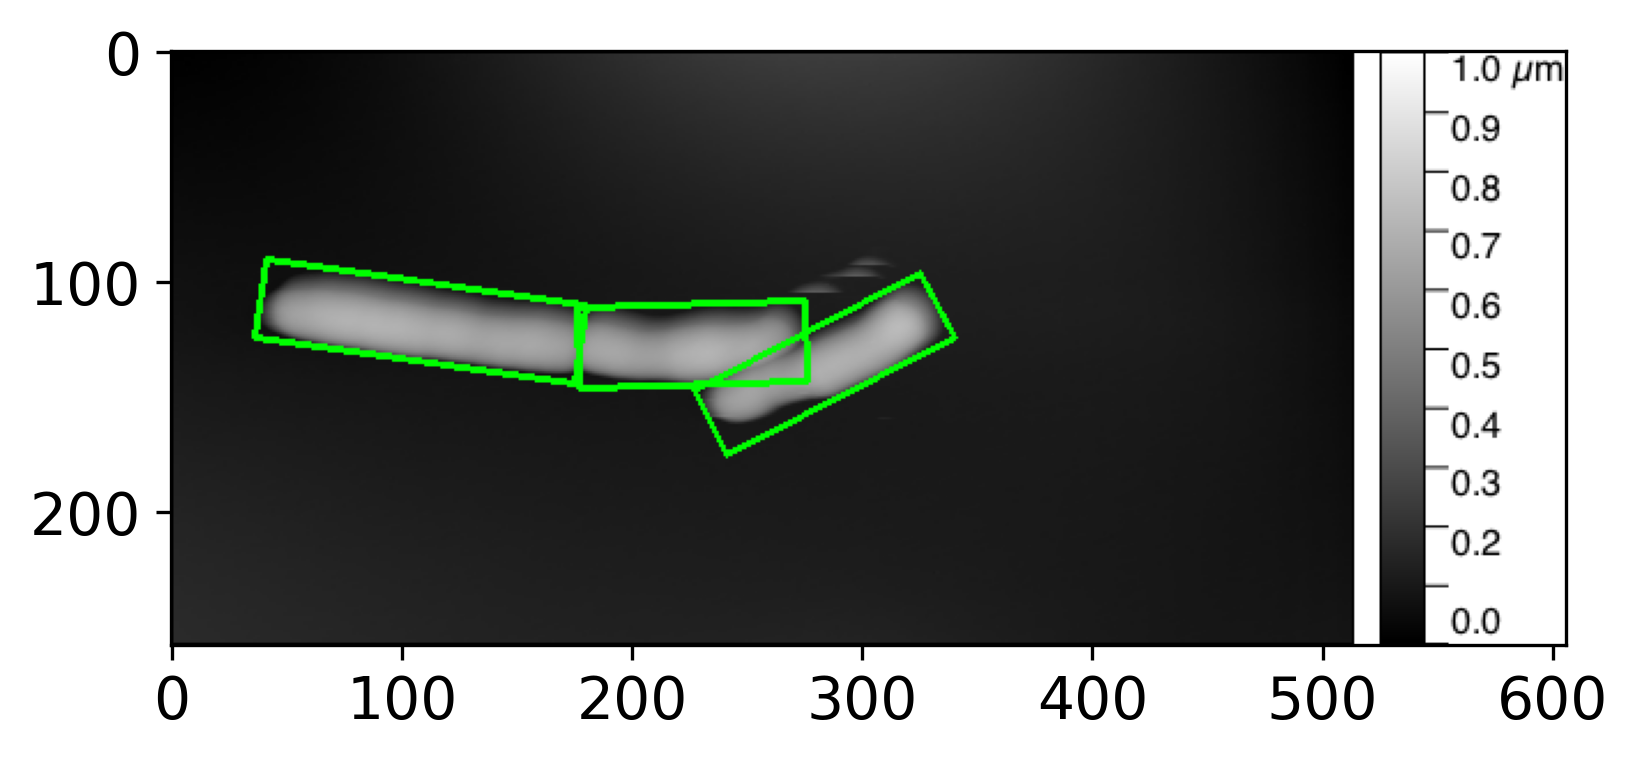

In [8]:
# create an example to illustrate the bounding boxes. 
plt.imshow(box_img[31])

### 3.2.3 Cell Tracking

by Samuel Munn

We execute single particle tracking algorithms on the centroids of masks to find the trajectories of cells in images. These methods measure the probability of a particle in an initial image moving to the position of a particle in a second image via brownian motion. It then it finds the most probable path over a short series of images, accounting for the fact that particles may dissappear in some frames. We use the method described in (Crocker and Grier, 1996) as implemented in the Trackpy package by Allan et al.

In [9]:
centers_list = []
for outls in outl_temp:
    centers = []
    for outl in outls:
        length = outl.shape[0]
        x_sum = np.sum(outl[:,0])
        y_sum = np.sum(outl[:,1])
        centers.append(np.array([x_sum/length,y_sum/length]))
    centers_list.append(centers)

In [10]:
C = pd.DataFrame(columns=['frame','y','x','bounding boxes', 'outlines'])
centerl_aligned=centers_list
for i in range(0,len(centerl_aligned)):
    for (center, bbox, outl) in zip(centerl_aligned[i],boxes_temp[i], outl_temp[i]):
        df2=pd.DataFrame({'frame':[i],'y':[center[0]],'x':[center[1]],'bounding boxes': [bbox], 'outlines': [outl]})
        C = pd.concat([C,df2],ignore_index=True, axis=0)
P = trackpy.link(C,40,memory=3)

Frame 96: 6 trajectories present.


In [11]:
pf = trackpy.filter_stubs(P,20)

In [12]:
P=P.set_index('frame')
pf = pf.set_index('frame')

In [13]:
IDs_list = []
ID_ind = P.index
centers_list = []
outl_list = []
bbox_list = []
for i in range(len(structural_dict['Time'])):
    if not(i in ID_ind):
        ID_set = []
        center_set = []
        outl_set = []
        bbox_set = []
    elif not(type(P.loc[i]) == pd.core.frame.DataFrame):
        ID_set = [P.loc[i]['particle']]
        center_set = [np.array(P.loc[i][['y','x']])]
        bbox_set = [P.loc[i]['bounding boxes']]
        outl_set = [P.loc[i]['outlines']]
    else:
        ID_set = list(P.loc[i]['particle'])
        centers_set = list(np.array(P.loc[i][['y','x']]))
        outl_set = list(P.loc[i]['outlines'])
        bbox_set = list(P.loc[i]['bounding boxes'])
    IDs_list.append(ID_set)
    centers_list.append(centers_set)
    outl_list.append(outl_set)
    bbox_list.append(bbox_set)

In [14]:
# Add our new lists to the proper dictionaries. 
structural_dict["IDs"] = IDs_list
structural_dict["outlines"] = outl_list
structural_dict["bounding_boxes"] = bbox_list

metadata_dict["centroids"] = centers_list

# Destroy the temporary lists to get some more space. 
boxes_temp.clear()
outl_temp.clear()

The below code outputs a series of images which illustrate the cell tracking process. One can observe new cell IDs being assigned as cell division events occur. These new IDs are then subsequently tracked over multiple images. 

In [ ]:
# Plot the outputs to see how the cells are tracked over time.
fig, ax = plt.subplots(2,2, figsize = (15,8))
ax[0][0].imshow(box_img[2])
ax[0][1].imshow(box_img[14])
ax[1][0].imshow(box_img[20])
ax[1][1].imshow(box_img[26])

#### 3.2.3.1 Manually adjust IDs



**If IDs have already been adjusted skip to below.** First we must remove any old data to avoid any doubles or redundant data from being imported back into the workflow when we retrieve this data later

In [189]:
dir_list = []
files_list = []
for dirpath, dirnames,files in os.walk(lin_path):
    if not(dirnames == []):
        for d in dirnames:
            shutil.rmtree(os.path.join(dirpath,d))
    if not(files == []):
        for f in files:
            os.remove(lin_path + files)

Next we create a new folder for each ID, and save an image of the outline overlayed on the height data. We name these images with the timestamp and ID, which we will reference later when we import the data back into python

In [190]:
all_IDs = []
for (time,ID_set,img,outl_set) in zip(structural_dict['Time'],structural_dict['IDs'],img_dict['Height'],structural_dict['outlines']):
    for (ID,outl) in zip(ID_set,outl_set):
        if not(ID in all_IDs):
            all_IDs.append(ID)
            os.mkdir(lin_path + '/' + str(ID))
        plt.ioff()
        plt.imshow(img)
        plt.plot(outl[:,0],outl[:,1],'r.')
        plt.savefig(lin_path + '/' + str(ID) + '/' + str(time) + '_' + str(ID) + '.png')
        plt.clf()

<Figure size 432x288 with 0 Axes>

**If IDs have been manually adjusted, skip to here.** Next we update the retrieve the data from our lineages folder to get the manually corrected IDs

In [15]:
all_IDs = [int(i) for i in os.listdir(lin_path)]
for (time, i, ID_set) in zip (structural_dict['Time'],range(len(structural_dict['Time'])),structural_dict['IDs']):
    for (ID,j) in zip(ID_set,range(len(ID_set))):
        ID_name = str(time) + '_' + str(ID) + '.png'
        if ID_name in os.listdir(lin_path + '/' + str(ID)):
            continue
        else:
            structural_dict['IDs'][i][j]  = np.nan
            for ID_new in all_IDs:
                if ID_name in os.listdir(lin_path + '/' + str(ID_new)):
                   structural_dict['IDs'][i][j] = ID_new
                   break

### 3.2.4 Determining the perimeter, area, and overlap of cells

by Keegan Flannagan

The first piece of metadata that will be collected for each cell within each image is the perimeter size, area, and degree of cell overlap. Perimeter and area can be quickly and easily calculated using the outlines outputted by Cellpose. The degree to which each cell overlaps with other cells can be calculated using the following algorithm:
1. Take the bounding box for one of the cells in the image. 
2. Detect if the bounding box from that cell intersects with any of the bounding boxes from the other cell in the image. 
3. If the bounding boxes do intercept, compare the distance between the pixels from the outlines. If the distance between the pixels is one, then add 1 pixel to the amount of overlap for that cell. 
4. Repeat steps 1-3 for every cell in every image. 


In [17]:
metadata_dict["Perimeter"], metadata_dict["Area"] = tools.peri_area(outl_list)

metadata_dict["Overlap"] = tools.get_overlap(outl_list, bbox_list)

### 3.2.5 Save individual cells and their outlines

by Keegan Flannagan

Here cells and their masks are saved to a new dictionary. This will contain all individual cell data

In [18]:
ind_cell_dict["Height"], ind_cell_dict["Mask"] = tools.extract_ind_cells(IDs_list, outl_list, img_dict["Height"])

### 3.2.6 Skeletonization of individual cells

by Samuel Munn

The algorithm takes the individual cell masks (Figure) as inputs. It then creates the topological skeleton of the mask's shape using the skeletonize function in skimage.morphology, Python's Scikit Image package. skeletonize uses Zhang's algorithm to create the skeleton from a binary image. (Zhang, 1984) This creates the initial skeleton, which often splits into two or more branches at either end of the cell (Figure). This workflow solves this problem by finding the poles of the cell and then extending the skeleton to those poles. This can be completed using the function "prune2" in tools.py.

To find the poles of the cell first the "explore_poles" function in tools.py finds the set $S$ of extreme points in the mask as follows: starting with a smoothed curve (a periodic 3-spline) fitted to the points in the outline we find the radius at any given point on the outline as the distance from the outline to it's centroid. We then find the set of extreme points to be all local maxima of this radial distance function. We then divide $S$ into two subsets based on which side of the short axis of bounding box the extreme points fall on. We will call these subsets $S_1$ and $S_2$. The poles $P_1$ and $P_2$ are then defined as the weighted averages of their respective subsets, weighted by the radii of the extreme points.

prune2 then executes an algorithm  then crop all skeletons which do not intersect the outline near the poles, and choose the longest path through the skeleton to be the basis for the centerline. We then fit a smooth curve to this path (a 3-spline), ending at the poles nearest to it's ends. If the curvature does not exceed a certain threshold (standard threshold is 0.2) then it is converted into a binary image and returned as the centerline. If the centerline's cuvature does exceed this threshold the ends of the path through the skeleton are cropped, and the process of fitting a spline repeated. This new spline is then converted to a binary image and returned as the centerline.

In [ ]:
#list of skeletons (before and after branch pruning) with associated timepoints
unpruned_skel_list=[]
skel_list = []
#list of masks with skeletons overlayed in black
over_list=[]
#lists of poles, lengths, and centroids
pole_list = []
length_list = []
centroid_list = []
for time, mask_set in zip(structural_dict["Time"], ind_cell_dict["Mask"]):
    unpruned_skel_set = []
    skel_set = []
    over_set = []
    length_set = []
    pole_set = []
    centroid_set = []
    #create skeletons; save masks, skeletons, and masks with skeletons as lists, save skeletons and skeletons with masks as images
    for mask in mask_set:
        new_mask=mask[:,:,0]>0
        unpruned_skel = tools.padskel(mask)
        outline = utils.masks_to_outlines(new_mask)
        long = np.shape(unpruned_skel)[0]<np.shape(unpruned_skel)[1]
        poles,centroid = tools.explore_poles(outline,long)
        skel,length,pts,s = tools.prune2(unpruned_skel,outline,new_mask,poles,sensitivity=5)
        over = invert(skel+invert(new_mask)) #the mask overlayed on the skeleton (boolean array)
        pole_set.append(poles)
        unpruned_skel_set.append(unpruned_skel)
        skel_set.append(skel)
        over_set.append(over)
        length_set.append(length)
    pole_list.append(pole_set)
    unpruned_skel_list.append(unpruned_skel_set)
    skel_list.append(skel_set)
    over_list.append(over_set)
    length_list.append(length_set)

In [ ]:
# Adding to dictionaries. 
ind_cell_dict["Skeleton"], ind_cell_dict["Skel + Mask"], ind_cell_dict["Unpruned"] = skel_list, over_list, unpruned_skel_list
metadata_dict["Length"] = length_list
metadata_dict["Poles"] = pole_list

In [ ]:
[start_pole,end_pole]=metadata_dict["Poles"][12][1]
skel = ind_cell_dict['Skel + Mask'][12][1]
plt.imshow(skel,cmap=plt.cm.gray)
plt.plot(start_pole[0],start_pole[1],'r.')
plt.plot(end_pole[0],end_pole[1],'r.')

### 3.2.7 Using RadFil to build and analyze the radial profile

by Keegan Flannagan

RadFil is a python package that was originally designed to measure the radial profiles of interstellar filaments, but can be readily applied to other structures such as cells (Zucker et al., 2018). Radfil was chosen for this analyses because it grants the user full control over the parameters used to build and fit the radial profiles and because of the convenient way it packages the output data.

RadFil takes the cell image, mask, and skeleton from each isolated cell as input. It then performs spline interpolation by fitting a b-spline to the original skeleton which creates a smoothed, continuous version of the original skeleton. RadFil then creates a series of cuts at even points along the skeleton which are perpendicular to the tangent of the skeleton at each cut point. These perpendicular cuts extend to the edge of the cell mask, and can therefore be used to compute the radius or diameter of the cell at every point along the skeleton. RadFil also saves the pixel intensities along the smoothed skeleton, which can be used to calculate the height along the skeleton which is also known as the ridgeline. 

In [ ]:
h_conv = 3.9215686274509802
s_conv = 392.15686274509802
p_conv = 1
# There is currently insufficient information supplied with the image files to convert the PFE pixel intensities to useful units. 

In [ ]:
%%capture

# For each image file we are analyzing, we are going to use RadFil to create a RadFil object and then extract the distance
# And pixel intensity profiles from each cell. 
metadata_dict["Intensity Profile"], metadata_dict["Ridgeline"], metadata_dict["Distance Profile"], metadata_dict["Width"] = tools.apply_radfil(ind_cell_dict["Height"],
                                                                                                                                         ind_cell_dict["Mask"], 
                                                                                                                                         ind_cell_dict["Skeleton"],
                                                                                                                                        conv = 3.9215686274509802)

In [ ]:
# Load the cell image
fil_image = ind_cell_dict["Height"][3][0][:,:,0]
            
# Load the cell mask and convert to a boolean array. 
fil_mask = ind_cell_dict["Mask"][3][0][:,:,0]>0

# Load the cell skeleton. 
fil_skeleton = ind_cell_dict["Skeleton"][3][0]>0
fil_skeleton[0,:] = False
            
# Use RadFil to create a radial profil object and then append this object to a list.
# We will use the data stored in this object to calculate height and radial profile along the
# medial axis. 
radobj=radfil_class.radfil(fil_image, mask=fil_mask, filspine=fil_skeleton, distance=200)
radobj.build_profile(samp_int=1, shift = False)

### 3.2.8 Organize everything into metadata tables

by Keegan Flannagan

Once all of the data has been collected for each individual image and cell, the data needs to be organized into a useful format. The following code loops through every cell ID that was assigned during cell tracking. For each Cell ID, it then loops through all of the data lists we have created and places all of the data for that image/timepoint into a row. If there was no data for a certain timepoint, the row is left empty. The result of this is a table for each cell that shows when that cell appeared/dissapeared along with its perimeter size, area, degree of overlap, center position, radial profile, ridgeline, and skeleton length at each timepoint. 

In [ ]:
# Find the last ID which was assigned during the cell tracking.
max_ID = tools.get_max_ID(structural_dict["IDs"])+1

# For each cell that was given an ID, Create a table of metadata. 
for i in range(max_ID):
    df = tools.get_metadata(metadata_dict, structural_dict, i)
    df.to_csv("metadata/05-10-2015/cell_id_" + str(i) + ".csv", index = False)

In [ ]:
ex = tools.get_metadata(metadata_dict, structural_dict, 0)
ex.head()

In [ ]:
profile = metadata_dict['Ridgeline'][12][1]
s = np.linspace(0,1,len(profile))
plt.plot(s,profile)

## 4. Results

by Keegan Flannagan and Samuel Munn

## 4.1 Height along the centerline

In [ ]:
In order to demonstrate the effectiveness of this automation method, we replicated figure 1a) from Eskandarian et al. 2017 using the data collected by our protocol.

The first step in generating these plot is to use our get_metadata function to get the data from cell zero and cell 2. Cell 2 is a daughter cell that splits off of cell 1.

In [ ]:
# Get metadata for cell 0
ex = tools.get_metadata(metadata_dict, structural_dict, 0)

# Get metadata for cell 2
ex2 = tools.get_metadata(metadata_dict, structural_dict, 2)

We then need to create a series of offsets in order to properly align the ridgelines onto the plot. 

In [ ]:
# This list of NA's is used to move the second cell into place so that its end aligns with the wave trough
na_list = []
for i in range(135):
    na_list.append(np.nan)

# These minimums are used to calculate offsets which align all of the first cells hieght profiles 
# Based on the location of te
minimums = []
for ridge in ex["Ridgeline"]:
    minimums.append(ridge.index(min(ridge)))
offsets = []
for mini in minimums:
    offsets.append(minimums[-1]-mini)

In [ ]:
# Create the plot by plotting each ridgeline on top of each other with the proper offsets. 
x = 0
fig,ax = plt.subplots(1,1,figsize=(10,20))
for ridge1,ridge2, i in zip(ex["Ridgeline"][14:27], ex2['Ridgeline'][14:27],range(len(ex["Ridgeline"][14:27]))):
    if np.isnan(ridge2).any() == True:
        skip = []
        for off in range(offsets[i]):
            skip.append(np.nan)
        ax.plot(np.array(skip+ridge1)+(x), color="k")
        x = x+500
    else:
        ax.plot(np.array(na_list+ridge2)+(x), color = "r")
        x = x+500

# Assign proper labels to all axes. 
ax.set_yticks([600])
ax.set_ylabel("Height (nm)", loc="bottom", fontsize = 13)
ax.set_xlabel("Length (pixels)", fontsize = 13)
ax2 = ax.twinx()
ax2.plot()
ax2.set_yticks([0], rotation=95)
ax2.set_yticklabels(["1"], fontsize = 11)
ax2.set_ylabel("Generation", fontsize = 13)
ax2.tick_params('y', colors='k')